# Business Understanging

**Objetivo do Dataset**
O cliente, no caso a COPPE/Poli/UFRJ apresenta uma base de dados que consiste em diversas séries temporais de alta amostragem de sinais de vibração de motores, onde foram simulados desalinhamentos horizontais e verticais, com o objetivo de reproduzir o comportamento de motores que gradativamente ficam defeituosos. Os analistas responsáveis pelo projeto são: Bruno Leal Fonseca e Guilherme Namen Pimenta, ambos igualmente responsáveis pelo andamento do projeto como um todo. O resultado do trabalho será usado para avaliar/monitorar a saúde de ativos de motores 
elétricos, alertando de possíveis danos causados no equipamento. 

Usar algoritmos de agrupamento, para conseguir segmentar regimes de operação nominal de motores elétricos dos regimes defeituosos, usando sinais de vibração dos rotores. Estabelecendo fronteiras entre os níveis aceitáveis e críticos dos equipamentos, para fazer manutenções com gastos minimizados. 

**Origem dos Dados**
O dataset foi desenvolvido pela equipe da Universidade Federal do Rio de Janeiro (UFRJ) e está disponível no portal do Grupo de Monitoramento e Diagnóstico de Sistemas Mecânicos (MDS). As medições foram realizadas em um motor com um rotor a 50 kHz e armazenadas em diferentes categorias com base nos tipos e severidades das falhas introduzidas.

**Características do Dataset**
- Estrutura do Dataset: O conjunto de dados está organizado em pastas que representam diferentes condições de falha, como desalinhamento horizontal e vertical, desequilíbrio, e condições normais. Subpastas indicam níveis de severidade específicos (exemplo: 0.5 mm de desalinhamento).

- Os dados consistem em várias planilhas CSV, cada uma delas apresenta os seguintes atributos:

    - tachometer: Medição do tacômetro.
    - underhang_1, underhang_2, underhang_3: Vibrações em sensores posicionados no lado inferior.
    - overhang_1, overhang_2, overhang_3: Vibrações em sensores posicionados no lado superior.
    - microphone: Medição de som/vibração ao redor do motor.

    - Linhas: Representam instantes de tempo durante a coleta de dados. No caso a amostragem foi feita a 50 kHz. Considerando que o registro durou 5 segundos, foram obtidas 250.000 amostras por registro. No total há cerca de 40 desses registros para cada tipo de estado dos motores.

**Relação com o Problema de Negócio**
Este dataset é relevante para o diagnóstico de falhas e a manutenção preditiva de sistemas industriais. A detecção de anomalias com base em medições de vibração pode:

1. Prevenir falhas catastróficas: Identificar tendências de falhas antes que elas ocorram.
2. Reduzir custos de manutenção: Implementar estratégias baseadas na condição real do motor, evitando manutenções desnecessárias.
3. Melhorar a eficiência operacional: Garantir o funcionamento contínuo e otimizado de sistemas industriais.
4. Redução de gastos com falhas inesperadas: Quando um motor falha, há grandes despesas para substituição parcial ou total do equipamento, além do prejuízo da produção ficar parada durante a inesperada manutenção e realocação de colaboradores

**Próximos Passos**
Com este entendimento inicial, podemos:

1. Primeiramente, será necessário reduzir um pouco o tamanho da base de dados, pelo fato de cada registro ser muito extenso e haverem diversos tipos de falhas que podem ocorrer, algumas delas serão simplificadas. As falhas do tipo Overhang e Underhang serão limitadas a apenas o tipo 'ball_fault'. Além disso, serão considerados os 3 piores cenários para cada tipo de falha.
2. Processar os dados para gerar atributos descritivos que capturam o comportamento vibracional do motor.
3. Aplicar algoritmos de agrupamento, como DBSCAN, para identificar padrões e possíveis anomalias.
4. Validar a eficácia do agrupamento utilizando os rótulos originais (normal e falhas), aplicando métricas de avaliação externas.

# Data Understanding & Data Preparation

A primeira coisa a ser feita é pensar como os dados devem ser tratados para os algoritmos de agrupamento. Como a base consiste em um número muito grande de registros, será feita uma engenharia de atributos para achar características que descrevem bem os sinais temporais. Usar os dados temporais provou-se ser muito ineficiente, pois mesmo falhas expressivas podem ser imperceptíveis no domínio do tempo.

Portanto, para cada planilha CSV foram extraídas características do sinal, depois todas elas são concatenadas em um único dataframe para ser levado à modelagem. Foram totalizadas 709 arquivos CSV (cada uma com 250.00 linhas), cada uma será tratada como um único registro no dataframe de atributos estimados.

Foi utilizada a Transformada Rápida de Fourrier (FFT), para extrair características do domínio da frequência, obtendo os harmônicos mais expressivos e suas frequências é possível descrever bem a vibração dos motores. Sinais temporais de alta amostragem, tal como vibração e corrente elétrica, tendem a ser bem consistentes, na presença de uma anomalia, os harmônicos tendem a deslocar ou mudar de módulo, também é possível que novos harmônicos apareçam indicando a falha. A imagem abaixo ilustra isso:

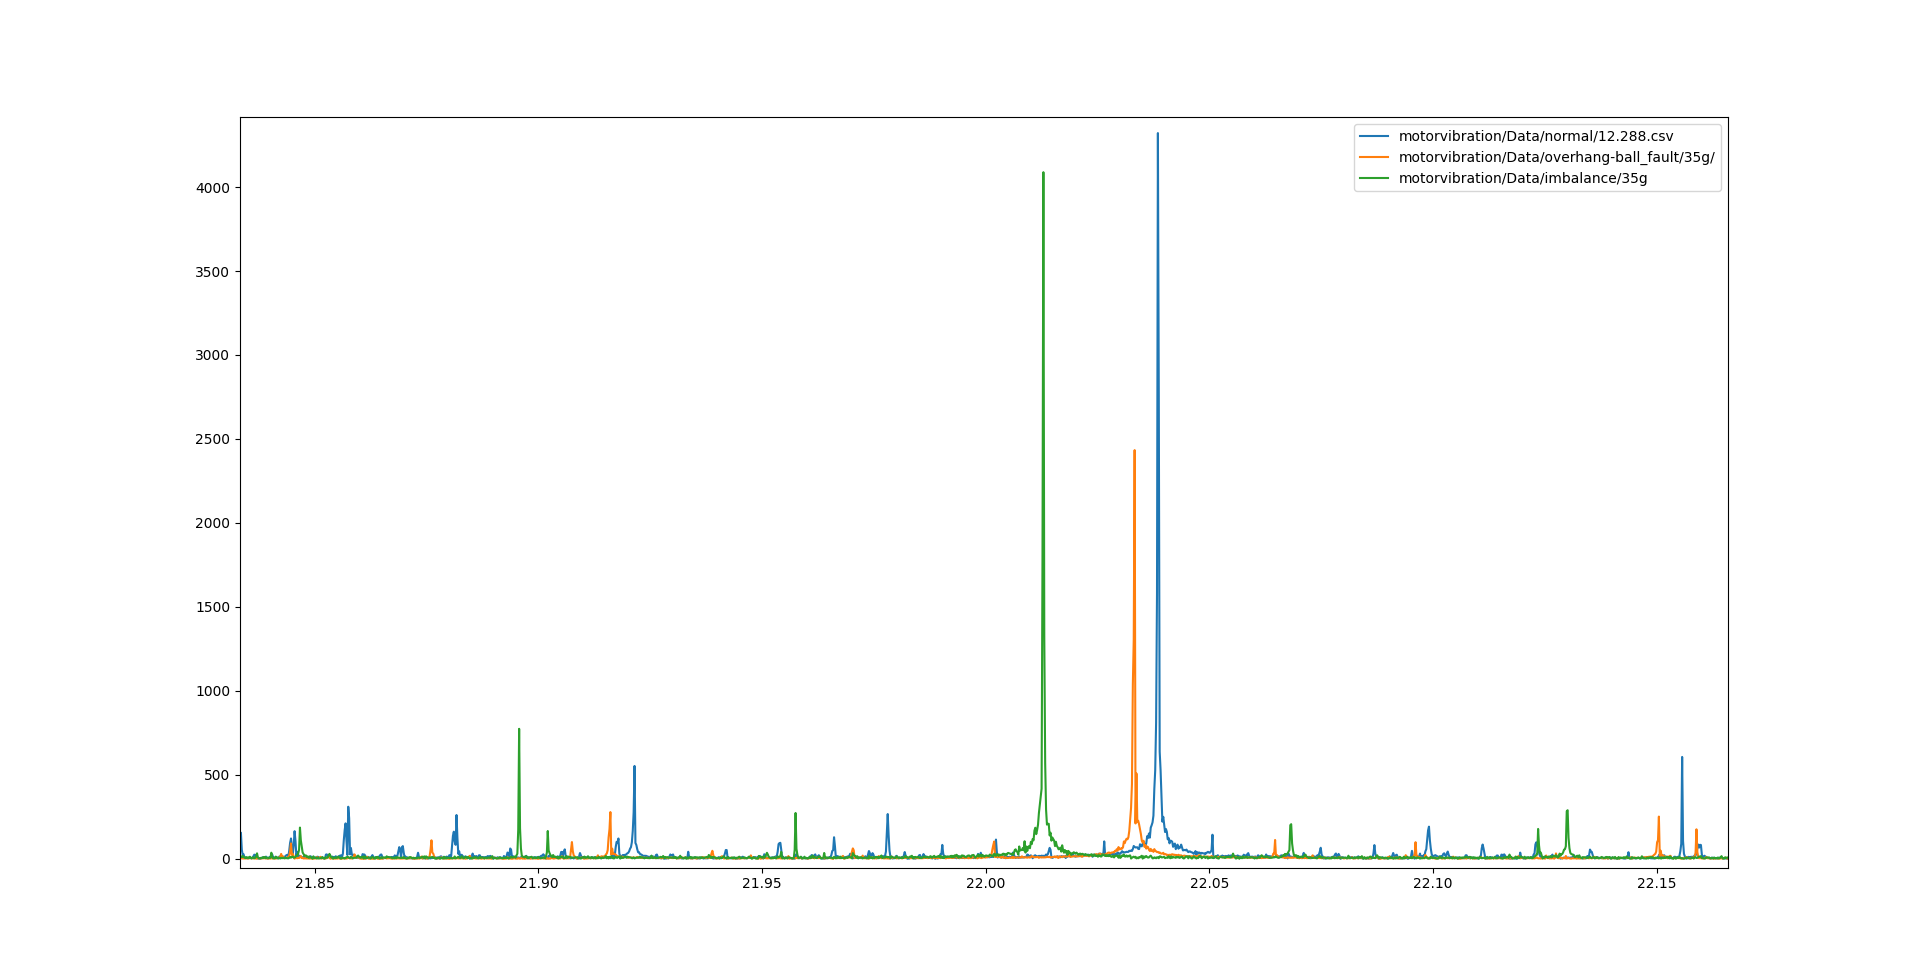

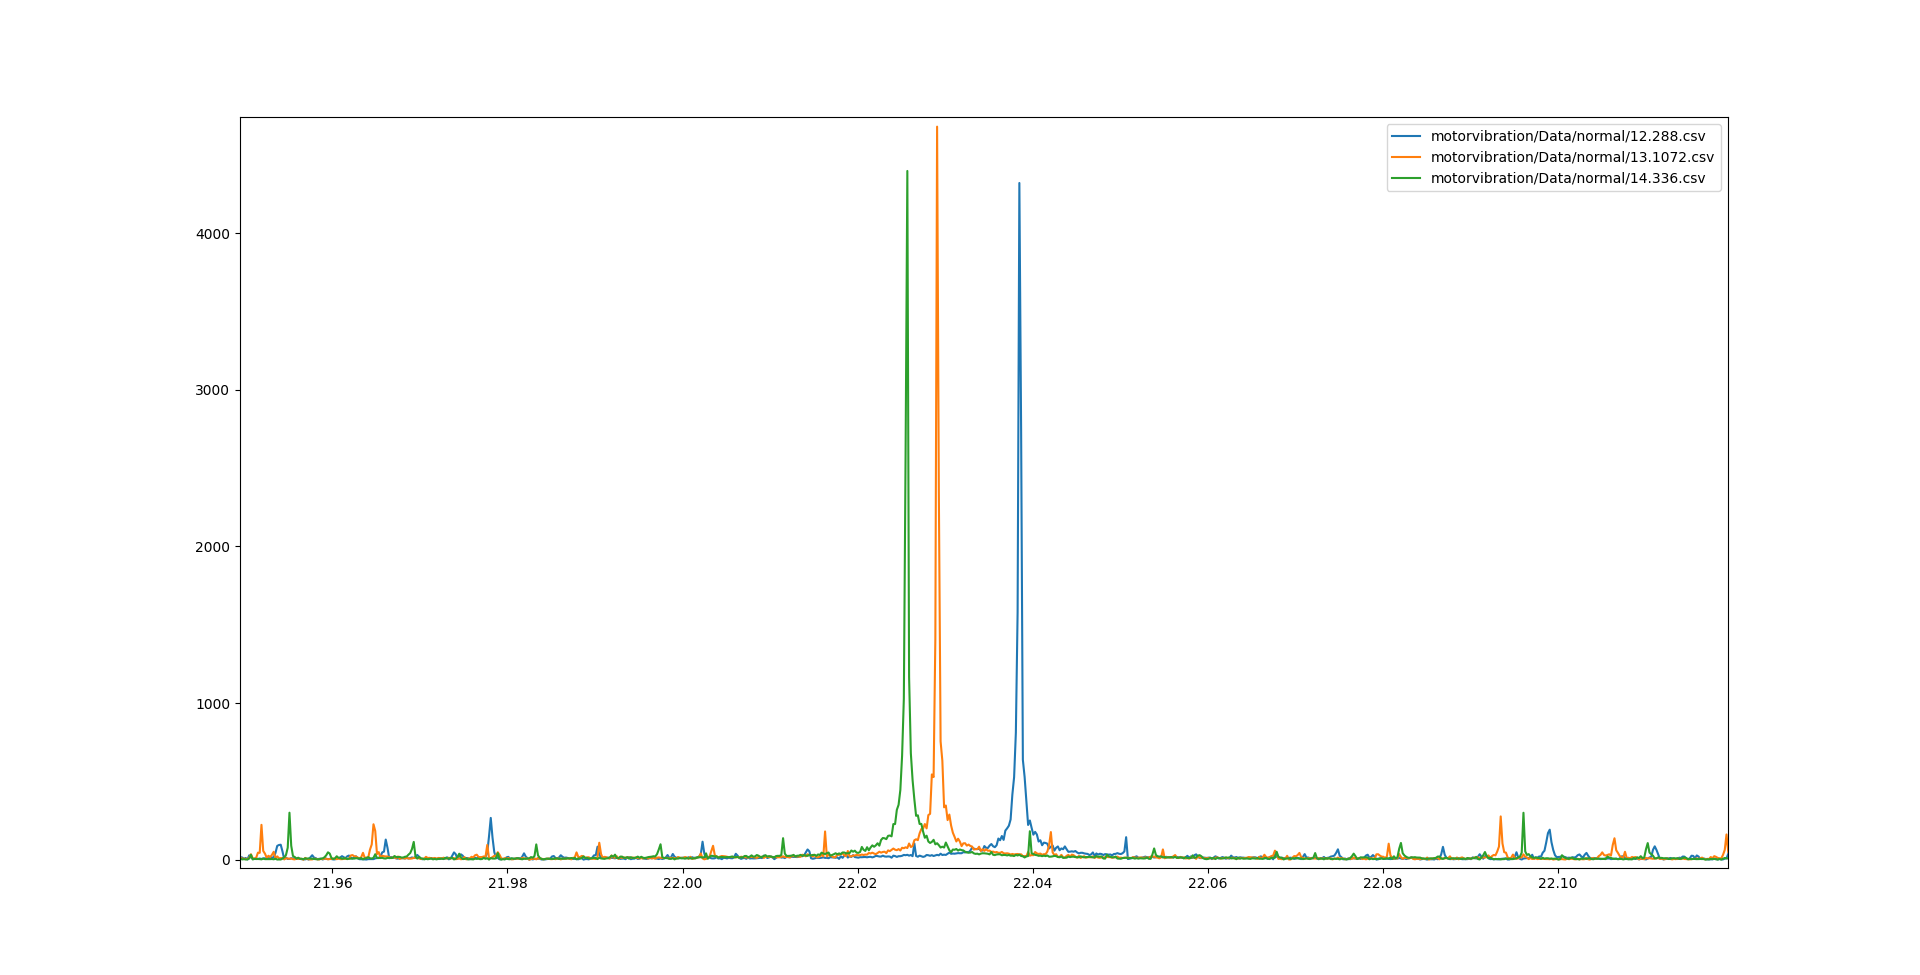

A base de dados original apresenta 8 colunas que foram medições de variáveis físicas por instrumentação, sendo duas delas o tacômetro medindo a velocidade e a outra o microfone medindo o ruído do rotor. 
Foram então selecionados os 500 harmônicos mais expressivos, pegando o módulo e frequência na qual ocorreram. Isso foi feito para cada uma das 8 colunas.

In [ ]:
def get_spectrum(self, p_y: np.ndarray) -> pl.DataFrame:
        yf = fftpack.fft(p_y)
        xf = fftpack.fftfreq(len(p_y), 1 / self.frequency_hz)
        spectrum_df = pl.DataFrame({"xf": xf, "yf": np.abs(yf)})

        return spectrum_df

def get_greatests_harmonics(self, p_df: pl.DataFrame, top_n: int, p_min_freq: float) -> pl.DataFrame:
    p_df = p_df.lazy().filter(pl.col("xf") > p_min_freq).collect()
    return p_df.sort(by="yf", descending=True).head(top_n)

def get_top_harmonics(
    self, p_name: str, p_df: pl.DataFrame, p_target_feature: str, p_freq_thresh: float, p_top_harmonics: int
) -> pl.DataFrame:
    spectrum_feat = {"file_name": p_name}
    spectrum_df = self.get_spectrum(p_df[p_target_feature].to_numpy())
    spectrum_df = self.get_greatests_harmonics(spectrum_df, p_top_harmonics, p_freq_thresh)

    for idx in range(p_top_harmonics):
        spectrum_feat[f"{p_target_feature}_harmonic_{idx+1}_frequency"] = spectrum_df.row(idx, named=True)["xf"]
        spectrum_feat[f"{p_target_feature}_harmonic_{idx+1}"] = spectrum_df.row(idx, named=True)["yf"]

    return pl.DataFrame(spectrum_feat)

Outra forma eficaz de extrair características de um sinal temporal são as Transformadas Wavelets. Similares à FFT, onde é feita uma decomposição de um sinal no domínio do tempo em diferentes componentes no domínio da frequência, as Transformadas Wavelets apresentam a virtude de não dependerem somente das funções seno e cosseno para encontrar essas componentes.

Há uma ampla gama de funções que podem ser aplicadas nessa tarefa e elas podem contribuir para realçar diferentes características do sinal de vibração. A chamada Wavelet-Mãe é a função oscilatória que será usada para caracterizar o sinal na discretização. Foi escolhida uma Wavelet da família Daubechies (db4), com ela serão extraídas tendencias nas baixas e altas frequências. O sinal pode ser separado em níveis ao ser decomposto, cada qual indicando componentes mais e mais específicos sobre o sinal.

A Transformada Wavelet retorna os coeficientes que compõem o sinal discretizado, trazendo assim os atributos que os caracteriza. Todavia, o problema de alta dimensionalidade se torna preocupante, já foram extraídos diversos harmônicos da FFT, e concatenar uma quantidade grandes de componentes pode ser problemático, pois como visto nas aulas, à medida que as dimensões aumentam, o centro do espaço de características vai ficando oco, e os pontos vão para as extremidades. Outro problema proveniente de uma dimensionalidade muito maior é que os pontos nas extremidades do espaço ficam equidistantes do centro, isso faz com que as medidas de distância usadas nos algoritmos de agrupamento fiquem ainda menos eficientes.

Logo, a saída foi estimar algumas estatísticas básicas dos componentes obtidos pela Transformada Wavelet.

In [ ]:
def get_wavelet_features(self, p_signal: np.ndarray, p_target: str, p_wavelet="db2", p_levels=4):
    # Decompor o sinal em níveis usando DWT
    coeffs = pywt.wavedec(p_signal, p_wavelet, level=p_levels)

    features = {}

    # Para cada nível de decomposição (aproximação e detalhes)
    for i, coeff in enumerate(coeffs):
        # Estatísticas dos coeficientes
        features[f"{p_target}_level_{i}_mean"] = np.mean(coeff)
        features[f"{p_target}_level_{i}_std"] = np.std(coeff)
        features[f"{p_target}_level_{i}_energy"] = np.sum(coeff**2)
        features[f"{p_target}_level_{i}_kurtosis"] = np.mean((coeff - np.mean(coeff)) ** 4) / (np.std(coeff) ** 4)
        features[f"{p_target}_level_{i}_skewness"] = np.mean((coeff - np.mean(coeff)) ** 3) / (np.std(coeff) ** 3)

    return pl.DataFrame(features)

Também foram estimadas algumas estatísticas de básicas no domínio do tempo, são elas: 
- min
- max
- mean
- var
- kurtosis
- skewness
- entropy

Essas estatísticas podem ser muito úteis no agrupamento, pois nota-se que em cada planilha CSV o experimento foi diferente, os valores de velocidade do tacômetro e as vibrações se comportam de maneiras diferentes, indicando que o motor pode ter sido colocado para rotacionar em regimes variados, com essas estatísticas básicas, o agrupamento pode ganhar uma camada de robustez ao levar em conta uma representação direta das variáveis físicas.

In [ ]:
def get_stats_features(self, p_df: pl.DataFrame, p_target_feature: str) -> pl.DataFrame:
    feat_dict = {}

    df = p_df.with_columns(
        [
            pl.col(p_target_feature).min().alias("min"),
            pl.col(p_target_feature).max().alias("max"),
            pl.col(p_target_feature).mean().alias("mean"),
            pl.col(p_target_feature).var().alias("var"),
            pl.col(p_target_feature).kurtosis().alias("kurtosis"),
            pl.col(p_target_feature).skew().alias("skewness"),
            pl.col(p_target_feature).abs().entropy(base=2).alias("entropy"),
        ]
    )
    feat_dict[f"{p_target_feature}_min"] = df["min"][0]
    feat_dict[f"{p_target_feature}_max"] = df["max"][0]
    feat_dict[f"{p_target_feature}_mean"] = df["mean"][0]
    feat_dict[f"{p_target_feature}_var"] = df["var"][0]
    feat_dict[f"{p_target_feature}_kurtosis"] = df["kurtosis"][0]
    feat_dict[f"{p_target_feature}_skewness"] = df["skewness"][0]
    feat_dict[f"{p_target_feature}_entropy"] = df["entropy"][0]

    return pl.DataFrame(feat_dict)

O código completo do gerador de atributos segue abaixo:

In [ ]:
from dataclasses import dataclass
import numpy as np
import polars as pl
from scipy import fftpack
import pywt
import matplotlib.pyplot as plt


@dataclass
class FeatureEngineering:
    dataset: pl.DataFrame
    frequency_hz: float

    def filter_operations(self, p_df: pl.DataFrame, p_operations_list: list):
        filtered_df_list = []
        for operation in p_operations_list:
            df = p_df.lazy().filter(pl.col("file_name").str.contains(f"{operation}")).collect()
            filtered_df_list.append((df, operation))

        return filtered_df_list

    def plot_features(self, p_column: str, p_motor_operations: list):
        filterd_dataset = self.dataset[[p_column, "file_name"]]
        filterd_dataset_list = self.filter_operations(filterd_dataset, p_motor_operations)

        legend = []
        plt.figure()
        for operation_df, operation_name in filterd_dataset_list:
            plt.plot(operation_df[p_column])
            legend.append(operation_name)
        plt.legend(legend)
        plt.show()

    def get_wavelet_features(self, p_signal: np.ndarray, p_target: str, p_wavelet="db2", p_levels=4):
        # Decompor o sinal em níveis usando DWT
        coeffs = pywt.wavedec(p_signal, p_wavelet, level=p_levels)

        features = {}

        # Para cada nível de decomposição (aproximação e detalhes)
        for i, coeff in enumerate(coeffs):
            # Estatísticas dos coeficientes
            features[f"{p_target}_level_{i}_mean"] = np.mean(coeff)
            features[f"{p_target}_level_{i}_std"] = np.std(coeff)
            features[f"{p_target}_level_{i}_energy"] = np.sum(coeff**2)
            features[f"{p_target}_level_{i}_kurtosis"] = np.mean((coeff - np.mean(coeff)) ** 4) / (np.std(coeff) ** 4)
            features[f"{p_target}_level_{i}_skewness"] = np.mean((coeff - np.mean(coeff)) ** 3) / (np.std(coeff) ** 3)

        return pl.DataFrame(features)

    def get_spectrum(self, p_y: np.ndarray) -> pl.DataFrame:
        yf = fftpack.fft(p_y)
        xf = fftpack.fftfreq(len(p_y), 1 / self.frequency_hz)
        spectrum_df = pl.DataFrame({"xf": xf, "yf": np.abs(yf)})

        return spectrum_df

    def get_greatests_harmonics(self, p_df: pl.DataFrame, top_n: int, p_min_freq: float) -> pl.DataFrame:
        p_df = p_df.lazy().filter(pl.col("xf") > p_min_freq).collect()
        return p_df.sort(by="yf", descending=True).head(top_n)

    def get_top_harmonics(
        self, p_name: str, p_df: pl.DataFrame, p_target_feature: str, p_freq_thresh: float, p_top_harmonics: int
    ) -> pl.DataFrame:
        spectrum_feat = {"file_name": p_name}
        spectrum_df = self.get_spectrum(p_df[p_target_feature].to_numpy())
        spectrum_df = self.get_greatests_harmonics(spectrum_df, p_top_harmonics, p_freq_thresh)

        for idx in range(p_top_harmonics):
            spectrum_feat[f"{p_target_feature}_harmonic_{idx+1}_frequency"] = spectrum_df.row(idx, named=True)["xf"]
            spectrum_feat[f"{p_target_feature}_harmonic_{idx+1}"] = spectrum_df.row(idx, named=True)["yf"]

        return pl.DataFrame(spectrum_feat)

    def get_stats_features(self, p_df: pl.DataFrame, p_target_feature: str) -> pl.DataFrame:
        feat_dict = {}

        df = p_df.with_columns(
            [
                pl.col(p_target_feature).min().alias("min"),
                pl.col(p_target_feature).max().alias("max"),
                pl.col(p_target_feature).mean().alias("mean"),
                pl.col(p_target_feature).var().alias("var"),
                pl.col(p_target_feature).kurtosis().alias("kurtosis"),
                pl.col(p_target_feature).skew().alias("skewness"),
                pl.col(p_target_feature).abs().entropy(base=2).alias("entropy"),
            ]
        )
        feat_dict[f"{p_target_feature}_min"] = df["min"][0]
        feat_dict[f"{p_target_feature}_max"] = df["max"][0]
        feat_dict[f"{p_target_feature}_mean"] = df["mean"][0]
        feat_dict[f"{p_target_feature}_var"] = df["var"][0]
        feat_dict[f"{p_target_feature}_kurtosis"] = df["kurtosis"][0]
        feat_dict[f"{p_target_feature}_skewness"] = df["skewness"][0]
        feat_dict[f"{p_target_feature}_entropy"] = df["entropy"][0]

        return pl.DataFrame(feat_dict)

    def plot_spectrum(self, p_column: str, p_motor_operations: list, p_freq_thresh: float):
        filterd_dataset = self.dataset[[p_column, "file_name"]]
        filterd_dataset_list = self.filter_operations(filterd_dataset, p_motor_operations)

        legend = []
        _, ax = plt.subplots()

        for operation_df, operation_name in filterd_dataset_list:
            spectrum_df = self.get_spectrum(operation_df[p_column].to_numpy())
            spectrum_df = spectrum_df.lazy().filter(pl.col("xf") > p_freq_thresh).collect()

            ax.plot(spectrum_df["xf"], spectrum_df["yf"])
            legend.append(operation_name)
        plt.legend(legend)
        plt.show()

In [ ]:
import os
from glob import glob
from dataclasses import dataclass
from ast import literal_eval
from dotenv import load_dotenv
from tqdm import tqdm
import polars as pl
from featureEngineering import FeatureEngineering


@dataclass
class DataLoader:
    dataset_path: str

    def list_files(self) -> list:
        csv_files_list = []

        folders_list = os.listdir(self.dataset_path)
        for folder in folders_list:
            folder_path = os.path.join(self.dataset_path, folder)
            if os.path.isdir(folder_path):
                sub_folders_list = os.listdir(folder_path)
                for sub_folder in sub_folders_list:
                    sub_folder_path = os.path.join(folder_path, sub_folder)
                    if os.path.isdir(sub_folder_path):
                        list_csv = glob(f"{sub_folder_path}/*.csv")
                        for csv_file in list_csv:
                            csv_files_list.append((csv_file, csv_file))
                    elif sub_folder_path.endswith(".csv"):
                        csv_files_list.append((sub_folder_path, sub_folder_path))

        return csv_files_list

    def get_feats_multiple_targets(
        self,
        p_df: pl.DataFrame,
        p_file: str,
        p_feat_eng: FeatureEngineering,
        p_targets_list: list,
        p_freq_thresh: float,
        p_top_harmonics: int,
    ):
        feats_list = []
        for target in p_targets_list:
            wavelet_feat = p_feat_eng.get_wavelet_features(p_df[f"{target}"].to_numpy(), target)
            stats_feat = p_feat_eng.get_stats_features(p_df, target)
            spectrum_feat = p_feat_eng.get_top_harmonics(
                p_file.replace("\\", "/"), p_df, target, p_freq_thresh, p_top_harmonics
            )
            all_feats = pl.concat([spectrum_feat, wavelet_feat, stats_feat], how="horizontal")
            feats_list.append(all_feats)

        return feats_list

    def load_dataset(
        self, p_target_features: str, p_sample_rate: int, p_freq_thresh: float, p_top_harmonics: int
    ) -> pl.DataFrame:
        csv_files_list = self.list_files()
        dataframes_list = []

        for file, sub_folder in tqdm(csv_files_list):
            sub_folder = sub_folder.replace("\\", "/")
            df = pl.read_csv(file, has_header=False, new_columns=literal_eval(os.environ["dataset_columns_name"]))
            feat_eng = FeatureEngineering(df, p_sample_rate)

            feats_list = self.get_feats_multiple_targets(
                df, file, feat_eng, p_target_features, p_freq_thresh, p_top_harmonics
            )

            spectrum_feats_df = pl.concat(feats_list, how="align")
            # spectrum_feats_df = self.get_fftconv_features(feat_eng, df, file)

            dataframes_list.append(spectrum_feats_df)

        full_df = pl.concat(dataframes_list)

        return full_df


if __name__ == "__main__":
    load_dotenv("motorvibration/config/.env")
    data_loader = DataLoader(os.environ["dataset_path"])
    dataset = data_loader.load_dataset(
        literal_eval(os.environ["target_feature"]), p_sample_rate=50000, p_freq_thresh=1000.0, p_top_harmonics=500
    )
    print(dataset)

    dataset.write_csv(f"{os.environ["dataset_path"]}/motor_vibration_dataset.csv")


# Modeling

Em seguida será feita a modelagem, nessa etapa será aplicado um algoritmo de agrupamento para que seja possível tentar discernir o conjunto de dados anômalos da operação normal. Primeiramente, para fins de visualização será plotado os datapoints em um eixo cartesiano, os eixos serão a frequência do harmônico mais expressivo e o respectivo módulo sobre a coluna de medição de vibração Overhang3. Dessa forma, será possível ter uma noção básica de como os atributos no domínio da frequência podem caracterizar o conjunto de dados.

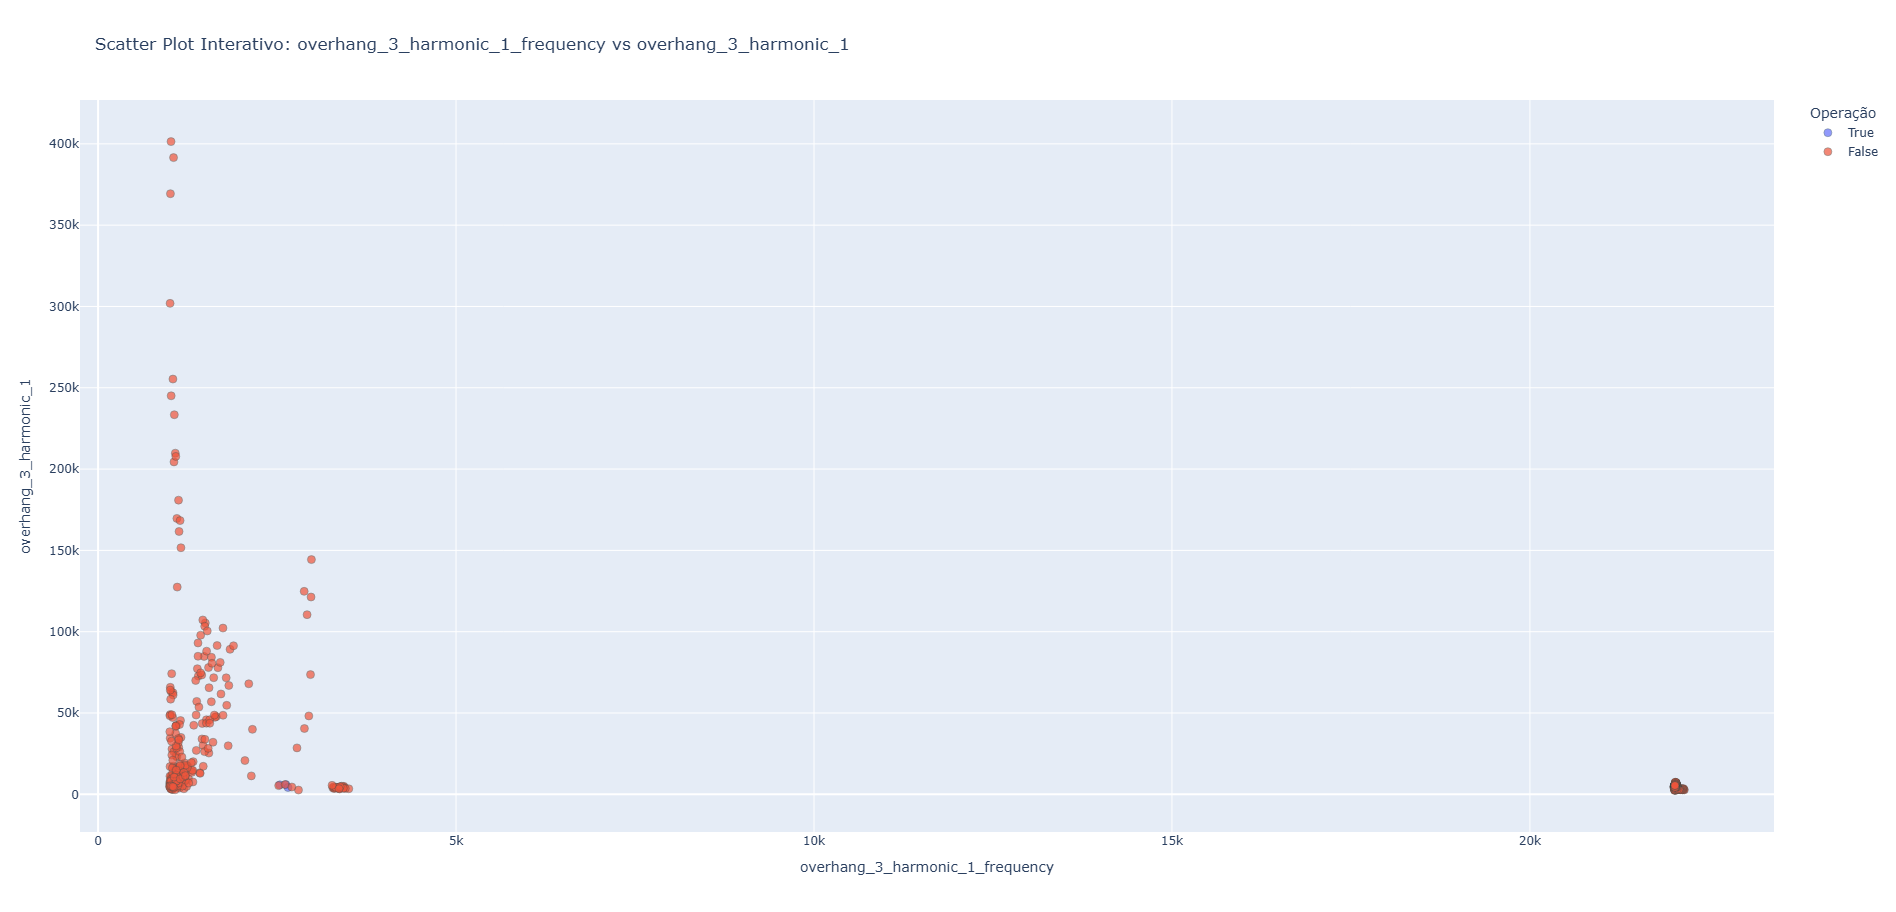

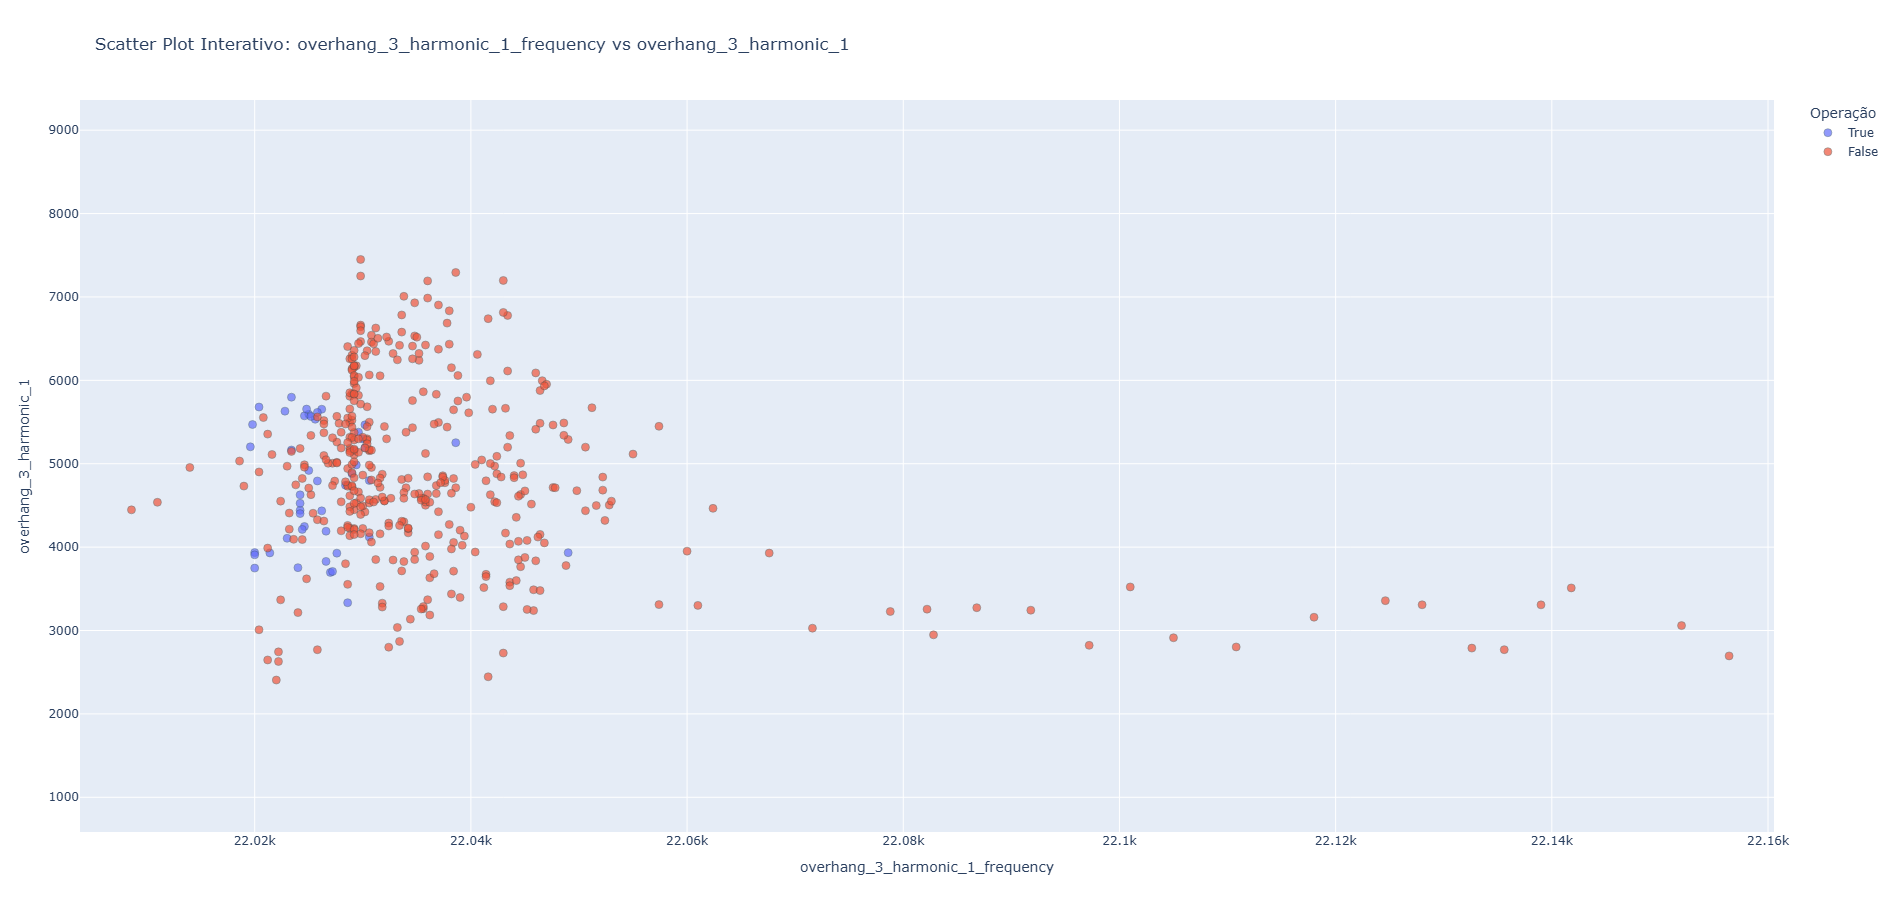

Ampliando no pequeno agrupamento na esquerda, é possível evidenciar que a maior parte dos dados de operação normal se aglomeram nessa região, junto de outros dados anômalos. Pode-se concluir que os harmônicos podem sim ajudar a discernir anomalias e operação nominal, contudo, apenas o harmônico mais expressivo está longe de ser suficiente para um agrupamento que permita discernir as classes.

Após a base de dados com as features estimadas para cada CSV ter sido carregada, o primeiro passo foi normalizar a base de dados. Contudo a base não foi normalizada levando em conta toda as amostras, mas usando os valores de operação normal como referência. Aplicando o MinMax Scaler, cada atributo foi normalizado em um range de 0.0 a 1.0, considerando os respectivos valores mínimo e máximo de cada atributo. Como se espera que o motor esteja operando normalmente, a base foi normalizada tendo a operação normal como referência e tudo fora desse range pode ser considerado anômalo.

Todavia, tendo uma base de dados de dimensões tão elevada, deseja-se saber se os atributos estimados foram suficientes para separar as classes de rótulos. Uma alternativa é usar o UMAP (Uniform Manifold Approximation and Projection), que consistem em uma técnica de redução de dimensionalidade que funciona para casos lineares, tal como o t-SNE, mas também casos gerais onde há não linearidade.

O algoritmo funciona assumindo que os dados seguem os 3 seguintes fundamentos:
1. Dados uniformemente distribuídos sob manifold Riemanniana;
2. A métrica Riemanniana é localmente constante (ou pode ser aproximada como tal);
3. A manifold é conectada localmente.

A partir dessas suposições, é possível modelar a mainfold com uma estrutura topológica Fuzzy. Os embeddings são encontrados na busca por projeções de baixa dimensionalidade dos dados com a estrutura topológica Fuzzy mais próxima o possível.

Aplicando o UMAP com os dados normalizados, conforme mencionado anteriormente, e utilizando a métrica de distância Manhattan nos hiperparâmetros, obteve-se o seguinte resultado:

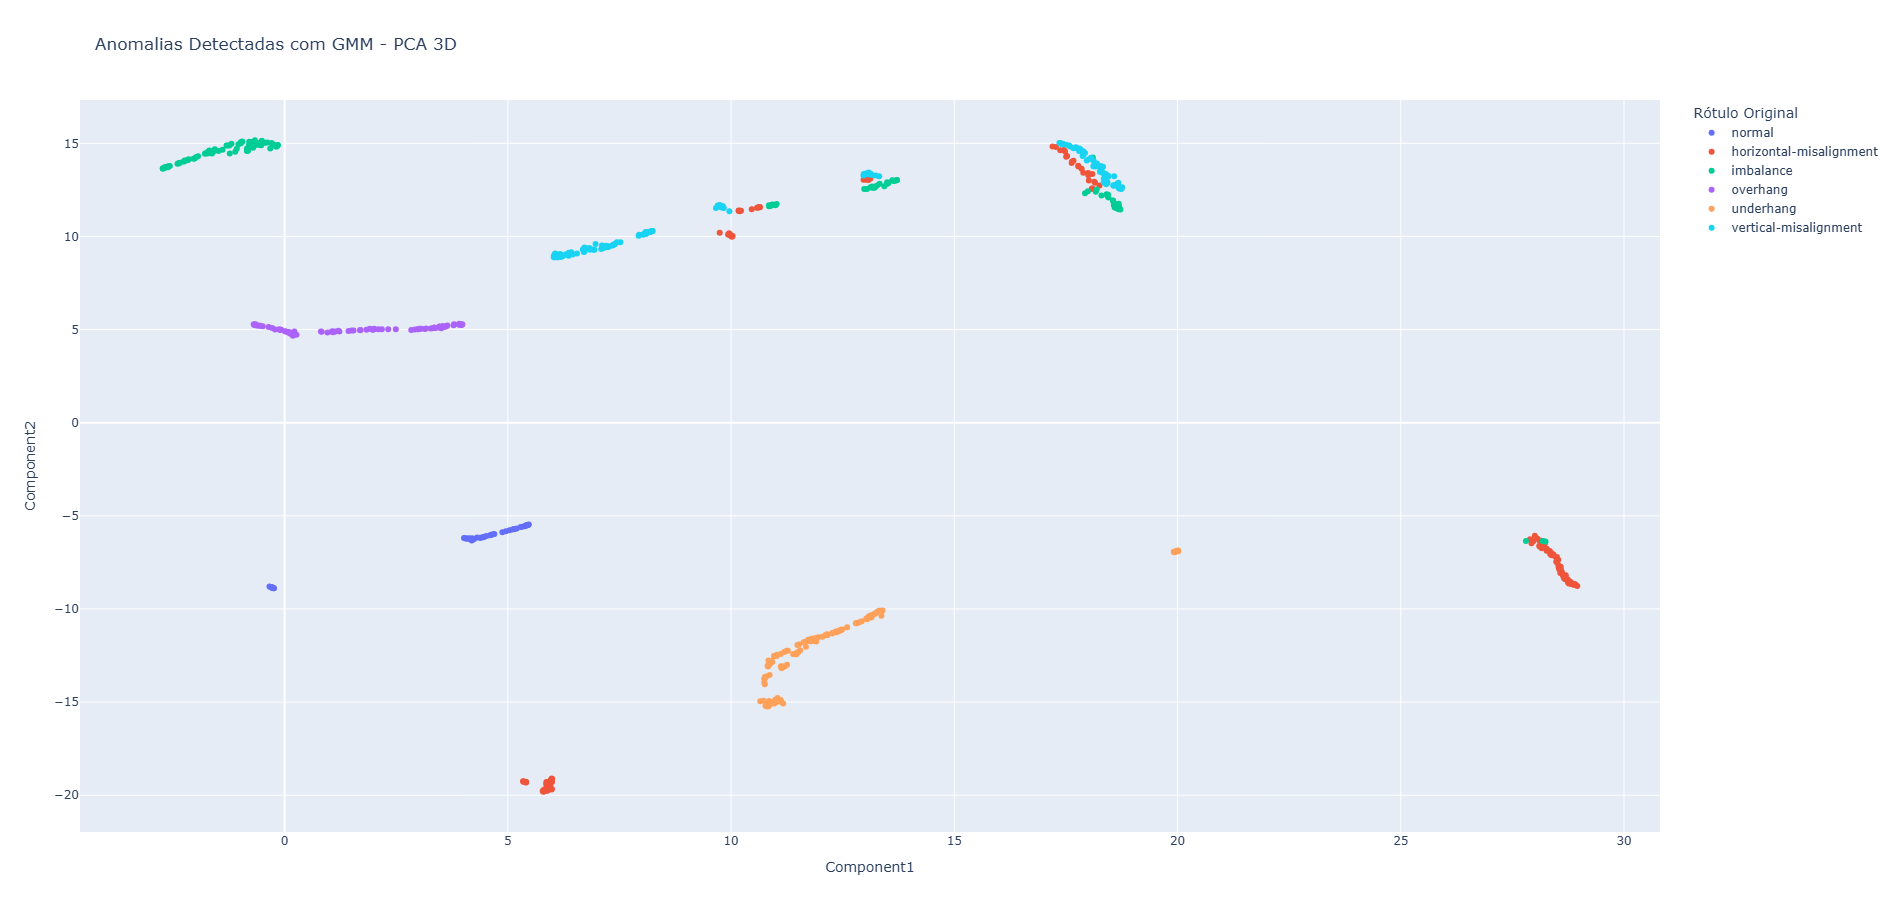

É possível validar que foi possível separar os dados de operações normais dos demais, alguns regimes de operação anômala ficam, inclusive, bem caracterizados no espaço de característica. É claro que o UMAP realizar uma redução de dimensionalidade, portanto não é uma representação 100% fiel do espaço de características, mas é possível ter uma noção da eficácia da engenharia de features.

Transformando os rótulos em binários para avaliar se o agrupamento consegue distinguir bem entre comportamento anômalo e normal:

![umap binary.png](<attachment:umap binary.png>)
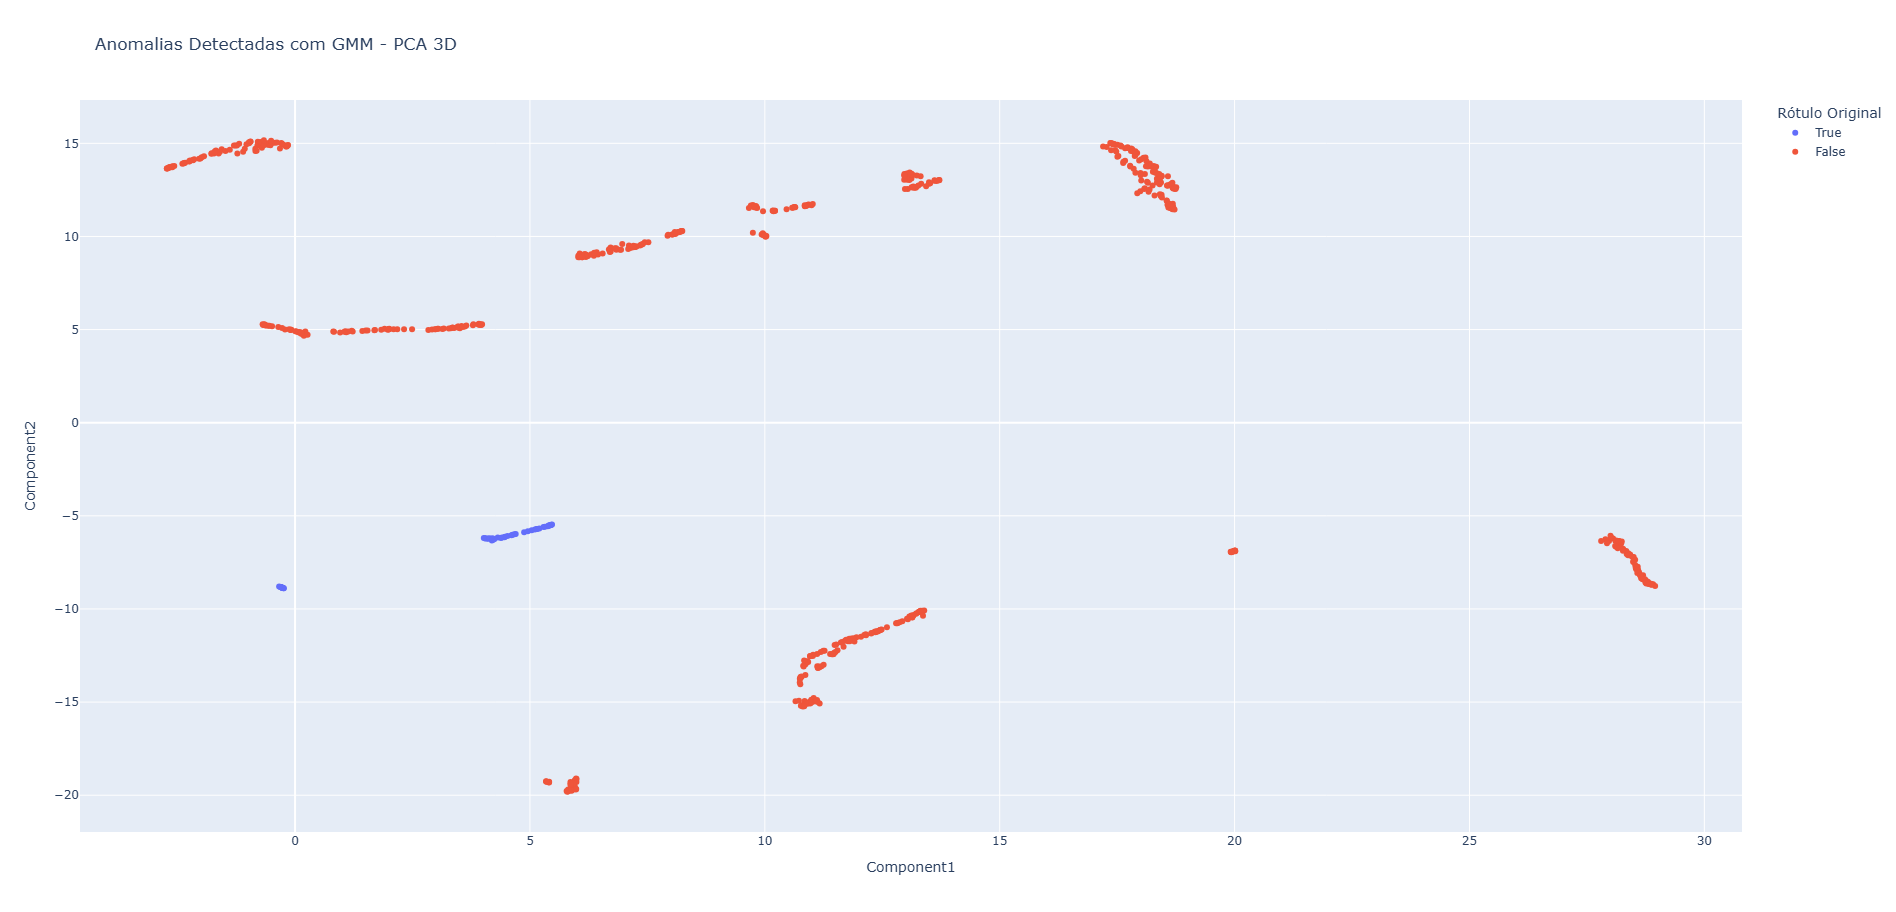

Por fim, foi aplicado o algoritmo DBSCAN para fazer o agrupamento, utilizando a distância euclidiana, ajustando os hiperparâmetros até achar uma ajuste ideal.

In [ ]:
import os
from ast import literal_eval
from dataclasses import dataclass
from dotenv import load_dotenv
import numpy as np
import polars as pl
import pandas as pd
import umap
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    v_measure_score,
    davies_bouldin_score,
    silhouette_score,
    calinski_harabasz_score,
)
import plotly.express as px


@dataclass
class Model:
    dataset_path: str

    def filter_motor_operation(self, p_df: pl.DataFrame, p_name: str) -> pl.DataFrame:
        return p_df.lazy().filter(pl.col("label") == p_name).collect()

    def filter_not_motor_operation(self, p_df: pl.DataFrame, p_name: str) -> pl.DataFrame:
        return p_df.lazy().filter(pl.col("label") != p_name).collect()

    def create_class_labels(self, p_df: pl.DataFrame, p_labels_name_list: list) -> np.array:
        labeled_df_list = []

        for label_name in p_labels_name_list:
            df = p_df.lazy().filter(pl.col("file_name").str.contains(f"{label_name}")).collect()
            df = df.with_columns(pl.lit(label_name).alias("label"))
            labeled_df_list.append(df)

        return pl.concat(labeled_df_list)

    def load_dataset(self):
        return pl.read_csv(self.dataset_path)

    def get_min_max_normalizer(self, p_df: pd.DataFrame) -> MinMaxScaler:
        return MinMaxScaler().fit(p_df)

    def normalize_data(self, p_df: pd.DataFrame):
        scaler = self.get_min_max_normalizer(p_df)
        return scaler, scaler.transform(p_df)

    def apply_normalizer(self, p_df: pd.DataFrame, p_scaler: MinMaxScaler):
        return p_scaler.transform(p_df)


if __name__ == "__main__":
    load_dotenv("motorvibration/config/.env")
    model = Model("motorvibration/Data/motor_vibration_dataset.csv")
    dataset = model.load_dataset()

    dataset = model.create_class_labels(dataset, literal_eval(os.environ["labels_list"]))

    normal_operation_df = model.filter_motor_operation(dataset, "normal")
    normal_operation_df = normal_operation_df.with_columns(pl.lit(True).alias("normal_operation"))

    not_normal_operation_df = model.filter_not_motor_operation(dataset, "normal")
    not_normal_operation_df = not_normal_operation_df.with_columns(pl.lit(False).alias("normal_operation"))

    all_motor_operations_df = pl.concat([normal_operation_df, not_normal_operation_df])
    print(all_motor_operations_df)

    harmonic = 1
    x_column = f"overhang_3_harmonic_{harmonic}_frequency"
    y_column = f"overhang_3_harmonic_{harmonic}"
    fig = px.scatter(
        all_motor_operations_df,
        x=x_column,
        y=y_column,
        color="normal_operation",
        hover_data=["file_name"],
        title=f"Scatter Plot Interativo: {x_column} vs {y_column}",
        labels={"normal_operation": "Operação Normal"},
    )
    fig.update_traces(marker=dict(size=8, opacity=0.7, line=dict(width=0.5, color="DarkSlateGrey")))
    fig.update_layout(
        xaxis_title=x_column,
        yaxis_title=y_column,
        legend_title="Operação",
    )
    fig.show()

    training_data = all_motor_operations_df.drop(["file_name", "label", "normal_operation"]).to_pandas()

    scaler, normal_data_scaled = model.normalize_data(
        normal_operation_df.drop(["file_name", "label", "normal_operation"]).to_pandas()
    )
    training_data_scaled = model.apply_normalizer(training_data, scaler)

    reducer = umap.UMAP(metric="manhattan", random_state=42)
    embeddings = reducer.fit_transform(
        X=training_data_scaled, y=all_motor_operations_df["normal_operation"].to_numpy()
    )

    plot_data = pd.DataFrame(embeddings, columns=["Component1", "Component2"])
    plot_data["Label"] = all_motor_operations_df["label"].to_numpy()

    fig = px.scatter(
        plot_data,
        x="Component1",
        y="Component2",
        color="Label",
        title="Anomalias Detectadas com GMM - PCA 3D",
        labels={"Anomaly": "É Anômalo", "Label": "Rótulo Original"},
    )

    fig.update_traces(marker=dict(size=6, opacity=1.0))
    fig.update_layout(scene=dict(xaxis_title="PCA1", yaxis_title="PCA2"))
    fig.show()

    dbscan = DBSCAN(eps=30.0)
    y_pred = dbscan.fit_predict(training_data_scaled)

    ari = adjusted_rand_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)
    nmi = normalized_mutual_info_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)
    v_measure = v_measure_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)

    print("Internal Metrics: \n")
    print("Adjusted Rand Index (ARI):", ari)
    print("Normalized Mutual Information (NMI):", nmi)
    print("V-Measure:", v_measure)

    print("External Metrics: \n")
    davies_bouding = davies_bouldin_score(training_data_scaled, y_pred)
    silhouette = silhouette_score(training_data_scaled, y_pred)
    calinski = calinski_harabasz_score(training_data_scaled, y_pred)
    print(f"davies_bouldin_score: {davies_bouding}")
    print(f"silhouette_score: {silhouette}")
    print(f"calinski_harabasz_score: {calinski}")

    plot_data = pd.DataFrame(embeddings, columns=["Component1", "Component2"])
    plot_data["Label"] = all_motor_operations_df["normal_operation"].to_numpy()
    fig = px.scatter(
        plot_data,
        x="Component1",
        y="Component2",
        color="Label",
        title="Anomalias Detectadas com GMM - PCA 3D",
        labels={"Label": "Rótulo Original"},
    )
    fig.update_traces(marker=dict(size=6, opacity=1.0))
    fig.update_layout(scene=dict(xaxis_title="Component1", yaxis_title="Component2"))
    fig.show()

    plot_data["Label"] = list(map(str, y_pred))
    fig = px.scatter(
        plot_data,
        x="Component1",
        y="Component2",
        color="Label",
        title="Anomalias Detectadas com GMM - PCA 3D",
        labels={"Anomaly": "É Anômalo", "Label": "Rótulo Agrupamento"},
    )
    fig.update_traces(marker=dict(size=6, opacity=1.0))
    fig.update_layout(scene=dict(xaxis_title="PCA1", yaxis_title="PCA2"))
    fig.show()

    y_pred = dbscan.fit_predict(training_data_scaled)
    y_pred[y_pred == 0.0] = 1.0

    ari = adjusted_rand_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)
    nmi = normalized_mutual_info_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)
    v_measure = v_measure_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)

    print("Adjusted Rand Index (ARI):", ari)
    print("Normalized Mutual Information (NMI):", nmi)
    print("V-Measure:", v_measure)

    plot_data["Label"] = list(map(str, y_pred))
    fig = px.scatter(
        plot_data,
        x="Component1",
        y="Component2",
        color="Label",
        title="Anomalias Detectadas com GMM - PCA 3D",
        labels={"Anomaly": "É Anômalo", "Label": "Rótulo Agrupamento"},
    )

    fig.update_traces(marker=dict(size=6, opacity=1.0))
    fig.update_layout(scene=dict(xaxis_title="PCA1", yaxis_title="PCA2"))

    fig.show()

    for eps in range(30, 150, 1):
        dbscan = DBSCAN(eps=eps)
        y_pred = dbscan.fit_predict(training_data_scaled)

        print(f"Eps: {eps}")
        davies_bouding = davies_bouldin_score(training_data_scaled, y_pred)
        silhouette = silhouette_score(training_data_scaled, y_pred)
        calinski = calinski_harabasz_score(training_data_scaled, y_pred)
        print(f"davies_bouldin_score: {davies_bouding}")
        print(f"silhouette_score: {silhouette}")
        print(f"calinski_harabasz_score: {calinski}")

    dbscan = DBSCAN(eps=69)
    y_pred = dbscan.fit_predict(training_data_scaled)
    plot_data["Label"] = list(map(str, y_pred))
    fig = px.scatter(
        plot_data,
        x="Component1",
        y="Component2",
        color="Label",
        title="Anomalias Detectadas com GMM - PCA 3D",
        labels={"Anomaly": "É Anômalo", "Label": "Rótulo Agrupamento"},
    )

    fig.update_traces(marker=dict(size=6, opacity=1.0))
    fig.update_layout(scene=dict(xaxis_title="PCA1", yaxis_title="PCA2"))

    fig.show()


![dbscan results.png](<attachment:dbscan results.png>)
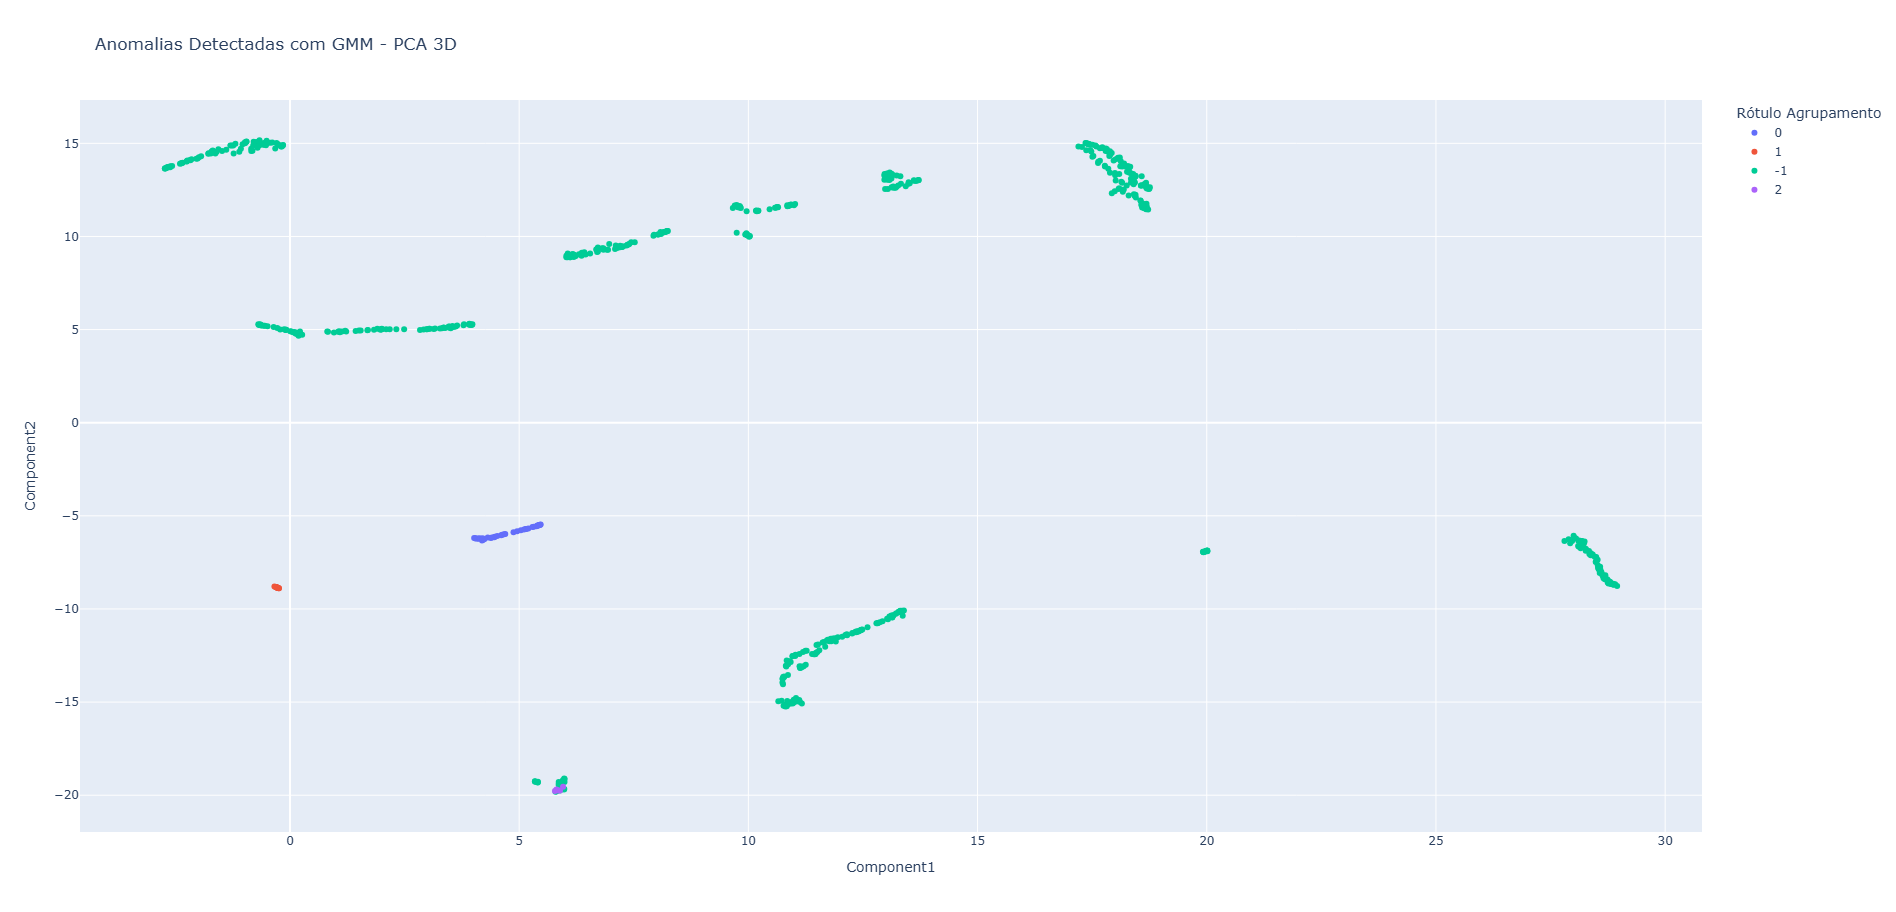

# Evaluation

Nota-se que os resultados obtidos pelo DBSCAN conseguiram identificar muito bem os clusters de operação normal. Uma parte dos dados de operação normal se distinguem da maioria, mas foram identificados com uma região próspera para um agrupamento. As demais amostras foram detectadas como ruídos, identificados pelo "-1", ou seja, regiões onde não foi possível identificar como pertencentes a nenhum agrupamento identificado, dados os parâmetros estabelecidos. Isso é interessante, pois os dados de operação normal não só se destacaram no espaço de atributos, como as demais anomalias foram identificadas como ruídos; esse evento pode ter ocorrido em virtude da normalização feita usando os dados de operação normal.

Alguns datapoints anômalos foram identificados como um pequeno agrupamento, mas impactaram pouco na performance obtida.

```
Adjusted Rand Index (ARI): 0.9370796412444163
Normalized Mutual Information (NMI): 0.862802283808055
V-Measure: 0.8628022838080549
```

[INSERIR EXPLICAÇÃO DAS MÉTRICAS DE QUALIDADE]

Caso o agrupamento "0" e "1" fossem unidos em um único grupo de operação normal, as métricas de qualidade indicariam que o agrupamento realizado foi ainda mais eficiente:

![dbscan results 2.png](<attachment:dbscan results 2.png>)

```
Adjusted Rand Index (ARI): 0.9442808178427418
Normalized Mutual Information (NMI): 0.9238050843288828
V-Measure: 0.9238050843288828
```
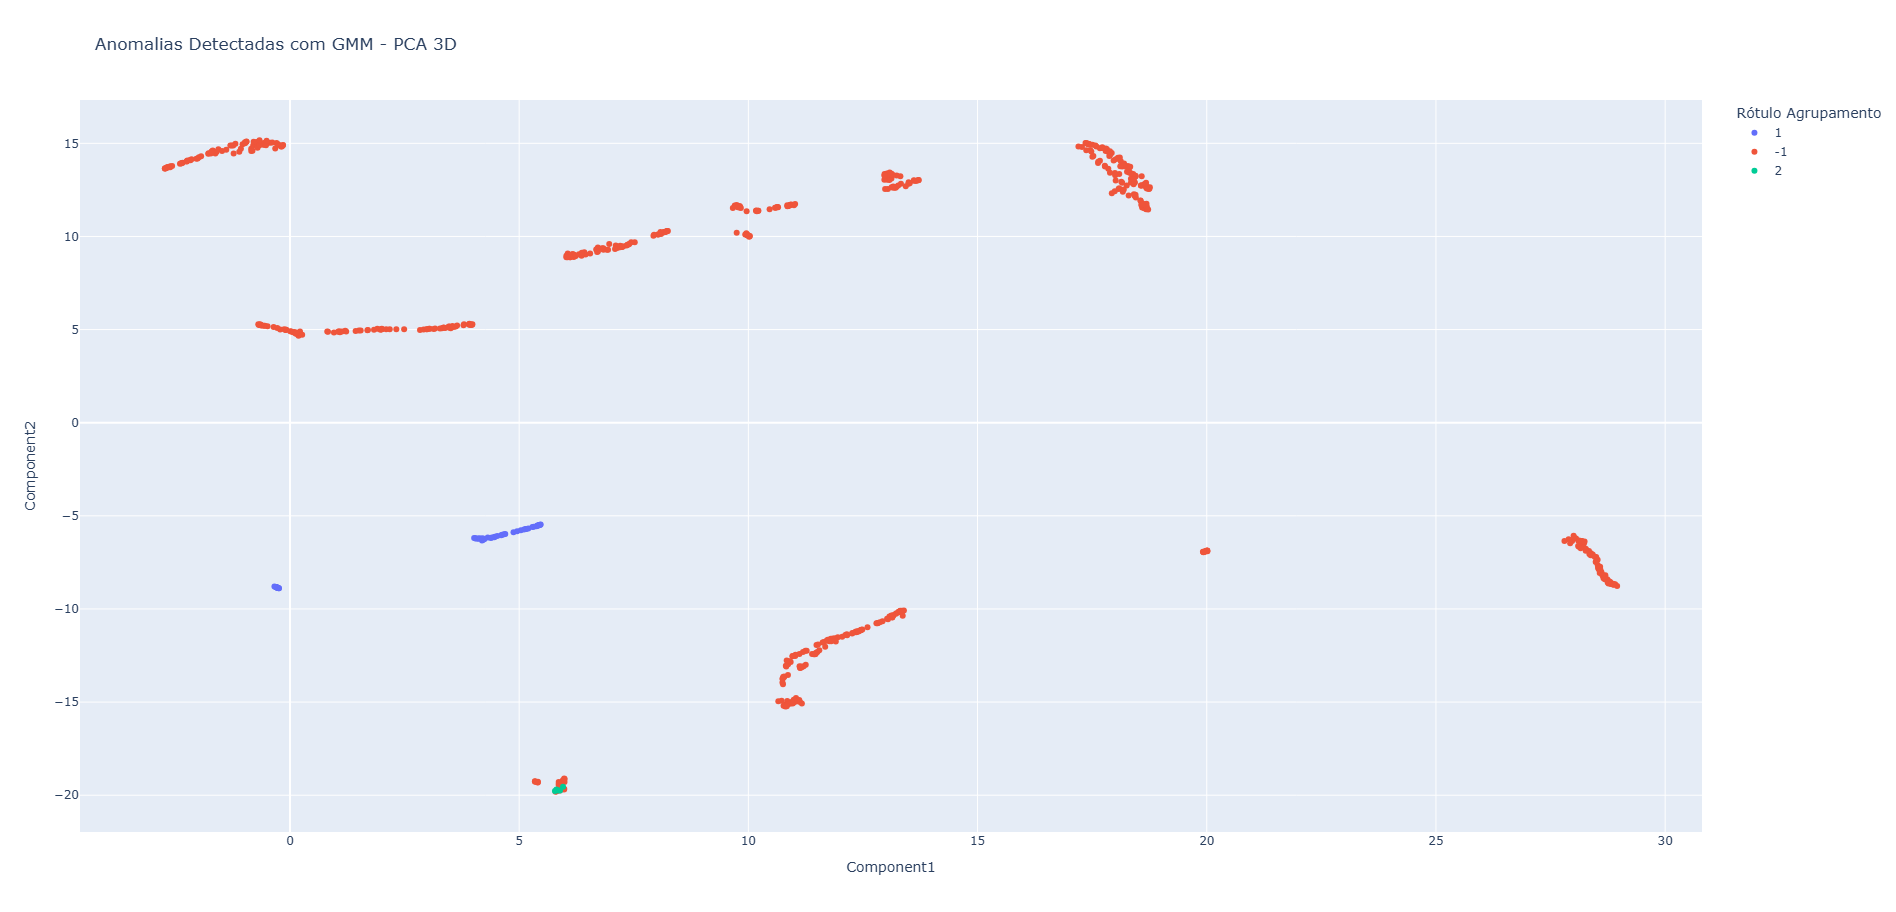

Contudo, essas métricas de qualidade dizem respeito apenas a um método externo de avaliar o agrupamento, ou seja, usando um conhecimento prévio que se tem do conjunto de dados. Dessa forma pode-se comparar a performance do agrupamento dados os rótulos dos datapoints.

Existem outras formas de avaliar um agrupamento, tais como as medidas internas, as quais não consideram rótulos. Elas avaliam a qualidade do agrupamento, usando medidas internas que permitem obter noções da similaridade intracluster, mas também da qualidade da separação de cada agrupamento, avaliando a separação intercluster. O compromisso geralmente é maximizar esses dois critérios, indicando assim um melhor agrupamento.

```
davies_bouldin_score: 1.9533343437203896
silhouette_score: -0.5804783638834314
```

É notável que os valores das métricas, na verdade, não indicam resultados bons. Analisando apenas no contexto de avaliar o intra e inter cluster, de fato o agrupamento não parece ser muito bem feito. A representação feita pelo UMAP indica claramente que existem regiões que potencialmente podem formar clusters adequados. No contexto das métricas externas os resultados foram excelentes, dados que a proposta inicial era detectar anomalias, mas olhando na perspectiva das métricas internas o agrupamento ficou a desejar.

Iterativamente foram feitos outros agrupamentos variando o valor do hiperparametro `eps`. Foram computados para cada caso as métricas externas:


Eps: 30
- davies_bouldin_score: 1.9533343437203896
- silhouette_score: -0.5804783638834314
- calinski_harabasz_score: 1.45821589912657


Eps: 31
- davies_bouldin_score: 1.9527859875944502
- silhouette_score: -0.5792509337494526
- calinski_harabasz_score: 1.487724080609991


Eps: 32
- davies_bouldin_score: 1.946524248997951
- silhouette_score: -0.558182784643921
- calinski_harabasz_score: 1.874529415691509


Eps: 33
- davies_bouldin_score: 1.9446760295992391
- silhouette_score: -0.5407953328137797
- calinski_harabasz_score: 1.6757955432354574


Eps: 34
- davies_bouldin_score: 1.9396235640828705
- silhouette_score: -0.5242706185223951
- calinski_harabasz_score: 1.5843218752146069


Eps: 35
- davies_bouldin_score: 1.9413774969583852
- silhouette_score: -0.4385793458797521
- calinski_harabasz_score: 2.183004631187894


Eps: 36
- davies_bouldin_score: 1.9345496891833895
- silhouette_score: -0.416480935235052
- calinski_harabasz_score: 2.490582415693891


Eps: 37
- davies_bouldin_score: 1.9282642817909568
- silhouette_score: -0.3966605384804958
- calinski_harabasz_score: 2.759225769791305


Eps: 38
- davies_bouldin_score: 1.903357764964467
- silhouette_score: -0.3648635169433811
- calinski_harabasz_score: 3.304669493498068


Eps: 39
- davies_bouldin_score: 1.8931352592772854
- silhouette_score: -0.33181429284979547
- calinski_harabasz_score: 3.7864589107840416

Eps: 40
- davies_bouldin_score: 1.876930087488728
- silhouette_score: -0.30184179779278286
- calinski_harabasz_score: 3.627698905115064

Eps: 41
- davies_bouldin_score: 1.869628899726609
- silhouette_score: -0.27859371126264904
- calinski_harabasz_score: 3.9353067005727085

Eps: 42
- davies_bouldin_score: 1.8639699884231513
- silhouette_score: -0.25953423419258465
- calinski_harabasz_score: 4.170519811980271

Eps: 43
- davies_bouldin_score: 1.856497533884653
- silhouette_score: -0.23771397044802628
- calinski_harabasz_score: 4.473025775396205

Eps: 44
- davies_bouldin_score: 1.91125070953886
- silhouette_score: -0.2016548808697595
- calinski_harabasz_score: 3.715662623402032

Eps: 45
- davies_bouldin_score: 1.9097400686512804
- silhouette_score: -0.16949607675673303
- calinski_harabasz_score: 3.6202949632935915

Eps: 46
- davies_bouldin_score: 1.8082317429535504
- silhouette_score: -0.12630197239202495
- calinski_harabasz_score: 4.613657572976993

Eps: 47
- davies_bouldin_score: 1.8218870402624803
- silhouette_score: -0.10272909893661081
- calinski_harabasz_score: 4.9101491558011405

Eps: 48
- davies_bouldin_score: 1.791851257440765
- silhouette_score: -0.08249742113159218
- calinski_harabasz_score: 5.987007499033713

Eps: 49
- davies_bouldin_score: 1.776824095455946
- silhouette_score: 0.019397931496841977
- calinski_harabasz_score: 7.781825474533268

Eps: 50
- davies_bouldin_score: 1.7680688801654456
- silhouette_score: 0.03733330250367431
- calinski_harabasz_score: 8.163949440150478

Eps: 51
- davies_bouldin_score: 1.7540852380394447
- silhouette_score: 0.06714591242979433
- calinski_harabasz_score: 8.772936819277666

Eps: 52
- davies_bouldin_score: 1.746945218641832
- silhouette_score: 0.08191399975458859
- calinski_harabasz_score: 9.090412152386358

Eps: 53
- davies_bouldin_score: 1.7381667376232643
- silhouette_score: 0.09808649669183177
- calinski_harabasz_score: 9.478495784534607

Eps: 54
- davies_bouldin_score: 1.7251475688460476
- silhouette_score: 0.12259367716707842
- calinski_harabasz_score: 10.061662283979059

Eps: 55
- davies_bouldin_score: 1.7145875238670258
- silhouette_score: 0.1388795506962828
- calinski_harabasz_score: 10.548167220158676

Eps: 56
- davies_bouldin_score: 1.711761357928636
- silhouette_score: 0.1437871084813333
- calinski_harabasz_score: 10.675623964911596

Eps: 57
- davies_bouldin_score: 1.708902233401605
- silhouette_score: 0.14868163476445073
- calinski_harabasz_score: 10.80479438185619

Eps: 58
- davies_bouldin_score: 1.7070256777179578
- silhouette_score: 0.13940285293312604
- calinski_harabasz_score: 9.363068513952527

Eps: 59
- davies_bouldin_score: 1.7036726803222995
- silhouette_score: 0.14684136111433668
- calinski_harabasz_score: 9.530572460349282

Eps: 60
- davies_bouldin_score: 1.6892846416841096
- silhouette_score: 0.047456814504399654
- calinski_harabasz_score: 8.608418418557735

Eps: 61
- davies_bouldin_score: 1.6791545285601461
- silhouette_score: 0.06472673120176295
- calinski_harabasz_score: 8.981542538958198

Eps: 62
- davies_bouldin_score: 1.6763096502187254
- silhouette_score: 0.09765214917443746
- calinski_harabasz_score: 10.622213293565267

Eps: 63
- davies_bouldin_score: 1.6732962203007635
- silhouette_score: 0.10170200697715451
- calinski_harabasz_score: 10.75069166534124

Eps: 64
- davies_bouldin_score: 1.6691797829013768
- silhouette_score: 0.1014863369854369
- calinski_harabasz_score: 10.945811613906892

Eps: 65
- davies_bouldin_score: 1.6675654902393364
- silhouette_score: 0.10313329424850508
- calinski_harabasz_score: 11.01331752792183

Eps: 66
- davies_bouldin_score: 1.6653146253168536
- silhouette_score: 0.1079868357821235
- calinski_harabasz_score: 11.14259090180371

Eps: 67
- davies_bouldin_score: 1.663681387366402
- silhouette_score: 0.1095049707041872
- calinski_harabasz_score: 11.21131778441864

Eps: 68
- davies_bouldin_score: 1.6620335245479334
- silhouette_score: 0.11110449665591625
- calinski_harabasz_score: 11.28060663412773

Eps: 69
- davies_bouldin_score: 1.6650554124475667
- silhouette_score: 0.24408802578467698
- calinski_harabasz_score: 13.555360351839559

Eps: 70
- davies_bouldin_score: 1.6586157030954667
- silhouette_score: 0.25376391122955405
- calinski_harabasz_score: 13.891471451726312

.
.
.

Calculando a variância na métrica interna calinski_harabaz_score, pode-se estimar qual foi o valor de `eps` que gerou o maior ganho, seguido de ganhos menores nos valores subsequentes. Executando para até o valor `eps=150`, foi retornado que o maior ganho segundo o calinski_harabaz_score foi o `eps=69`:

Eps: 69
- davies_bouldin_score: 1.6650554124475667
- silhouette_score: 0.24408802578467698
- calinski_harabasz_score: 13.555360351839559

E de fato os valores indicados pelas métricas indicam um agrupamento que foi mais adequado ao avaliar o intra e inter cluster, plotando os resultados na representação do UMAP:

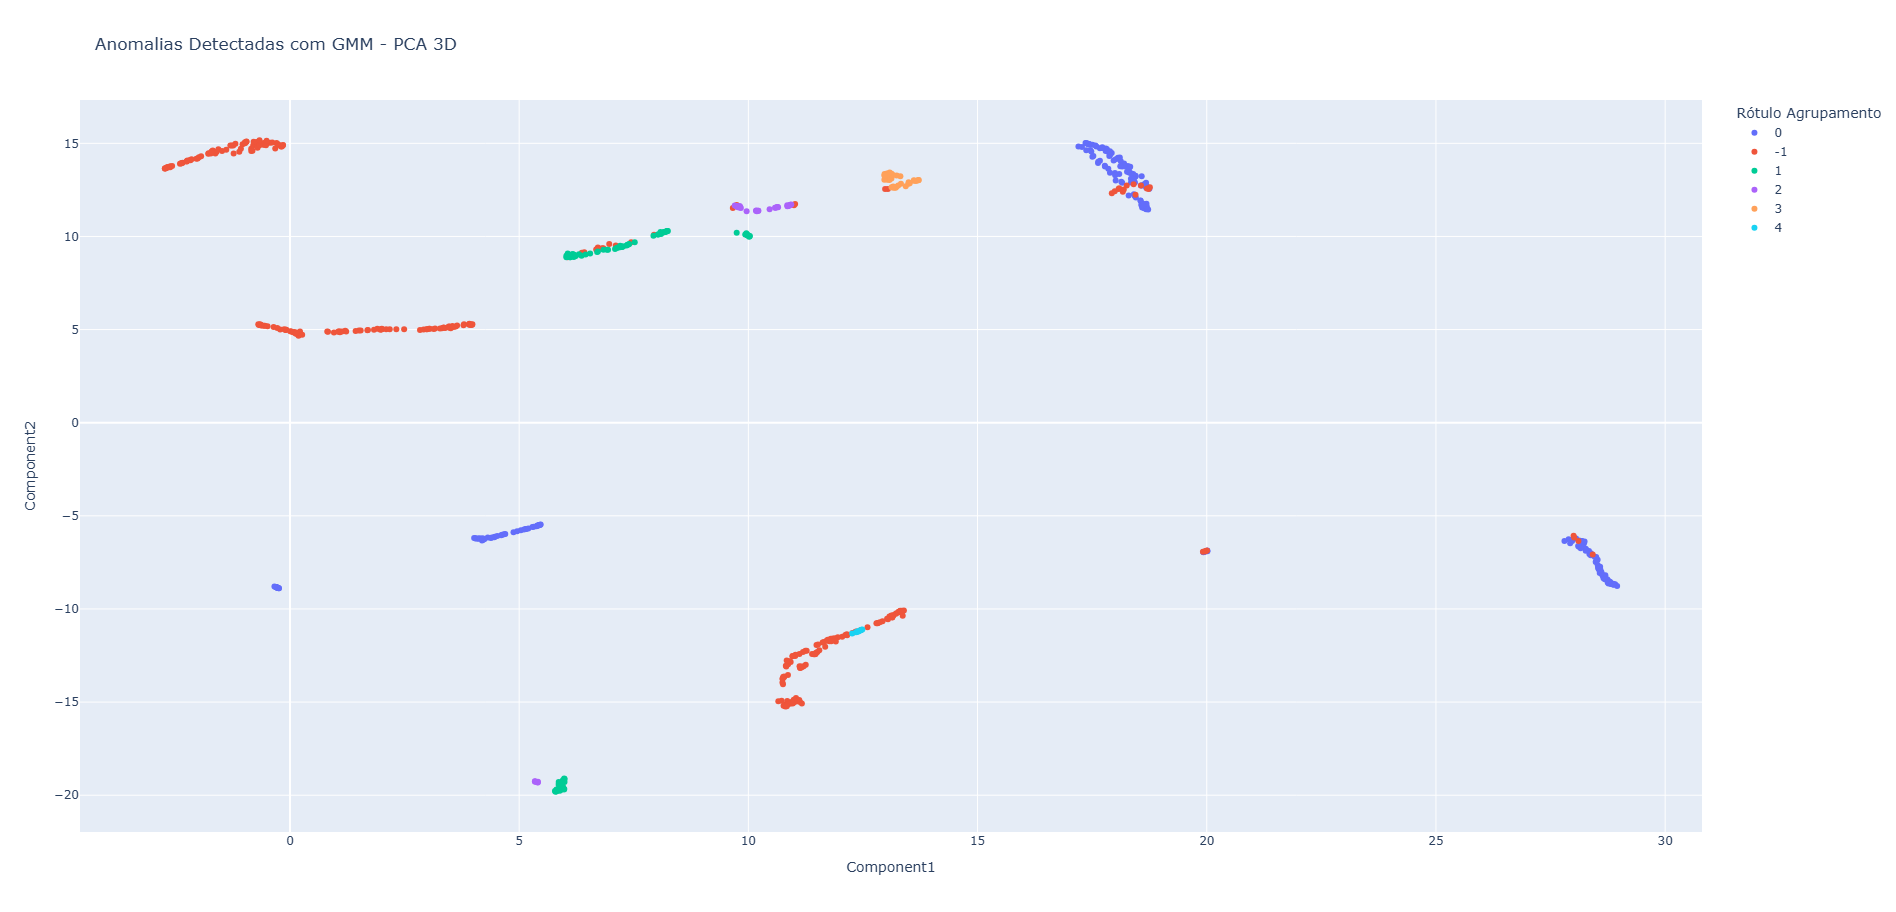